In [1]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [2]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/body splashes/bodysplash_amazon.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("antiperspirant|Antiperspirant", na=False)]
print(df)


                                                 title       price  \
170  #30 Fruity Body Spray,Brazilian Parfums Crush ...   SAR 67.60   
284  & 100ML Body Lotion Coconut Water & Mimosa Flower   SAR 18.44   
224        2016 Pure Seduction Body Lotion - Pack of 1   SAR 75.00   
319  22# Fruity Body Spray,Hair and Body Mist,Hair ...   SAR 67.99   
321  26# Fruity Body Spray,Perfume Cru-sh Fragrance...   SAR 65.58   
..                                                 ...         ...   
176                              perfume 812 for women   SAR 13.46   
106                          perfume for women , 25 ml   SAR 15.00   
22                      summer body spray 184 , 250 ml   SAR 23.00   
302  womens Splash Elastic Waist Hybrid Swim Short ...   SAR 89.66   
301  womens Splash Elastic Waist Hybrid Swim Short ...  SAR 279.17   

                 rating                                               link  \
170  2.3 out of 5 stars  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...   
284

In [20]:
import pandas as pd
from difflib import SequenceMatcher

def is_body_splash_or_fragrance(name):
    name = str(name).lower()
    
    # Keywords that must appear or match closely
    keywords = [
        "body splash", "fragrance mist", "body mist", "body spray",
        "perfume", "eau de toilette", "eau de parfum", "fragrance", "mist", "spray"
    ]

    # Optional: Exclude unrelated mist products (e.g., setting spray, toner)
    exclude_keywords = [
        "setting spray", "toner", "serum", "deodorant", "sunscreen"
    ]

    for exclude in exclude_keywords:
        if exclude in name:
            return False

    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True

    return False

# Apply to DataFrame
df = df[df['title'].apply(is_body_splash_or_fragrance)]
df.reset_index(drop=True, inplace=True)


In [4]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two|2pcs)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df["title"].apply(is_multi_item)

# Split the DataFrame
sets_df = df[mask_sets].copy()
df = df[~mask_sets].copy()

# Optional: Reset index if needed
sets_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
# Only compute if both volume and price are available
df["price_per_volume"] = df.apply(
    lambda row: row["price_numeric"] / row["volume"]
    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0
    else None,
    axis=1
)


In [6]:
print(df["price_numeric"].describe())


count    195.000000
mean      65.821897
std       52.509322
min       10.200000
25%       27.595000
50%       55.530000
75%       86.895000
max      361.000000
Name: price_numeric, dtype: float64


In [7]:
print(df["price_per_volume"].describe())


count    155.000000
mean       0.431323
std        0.544606
min        0.022788
25%        0.161680
50%        0.291907
75%        0.460597
max        4.007333
Name: price_per_volume, dtype: float64


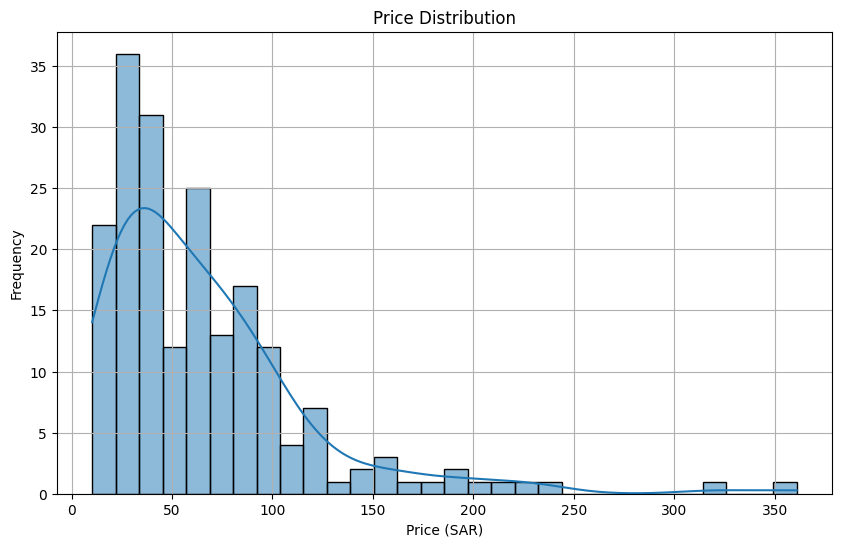

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [9]:
df_cleaned = df.dropna(subset=["title", "price_numeric","price_per_volume"])
df_cleaned.shape

(155, 8)

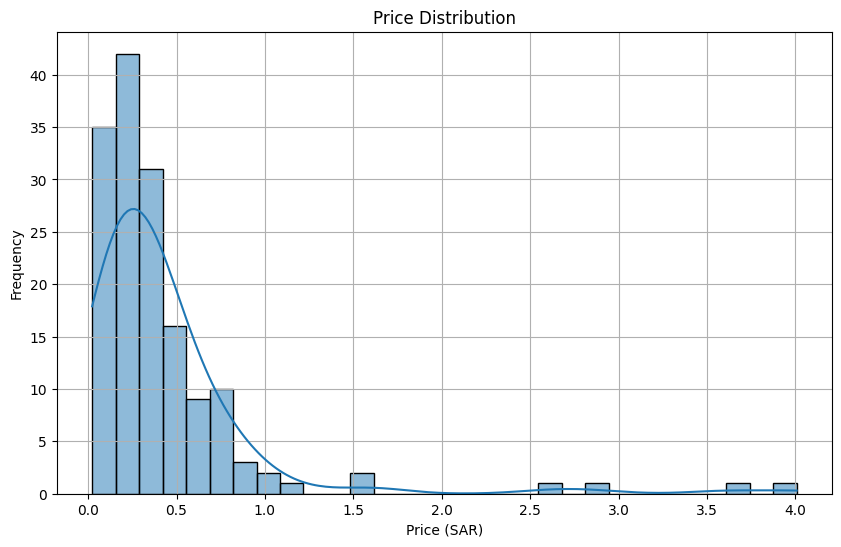

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["price_per_volume"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned = df_cleaned.copy()
df_cleaned["price_log"] = np.log1p(df_cleaned["price_per_volume"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

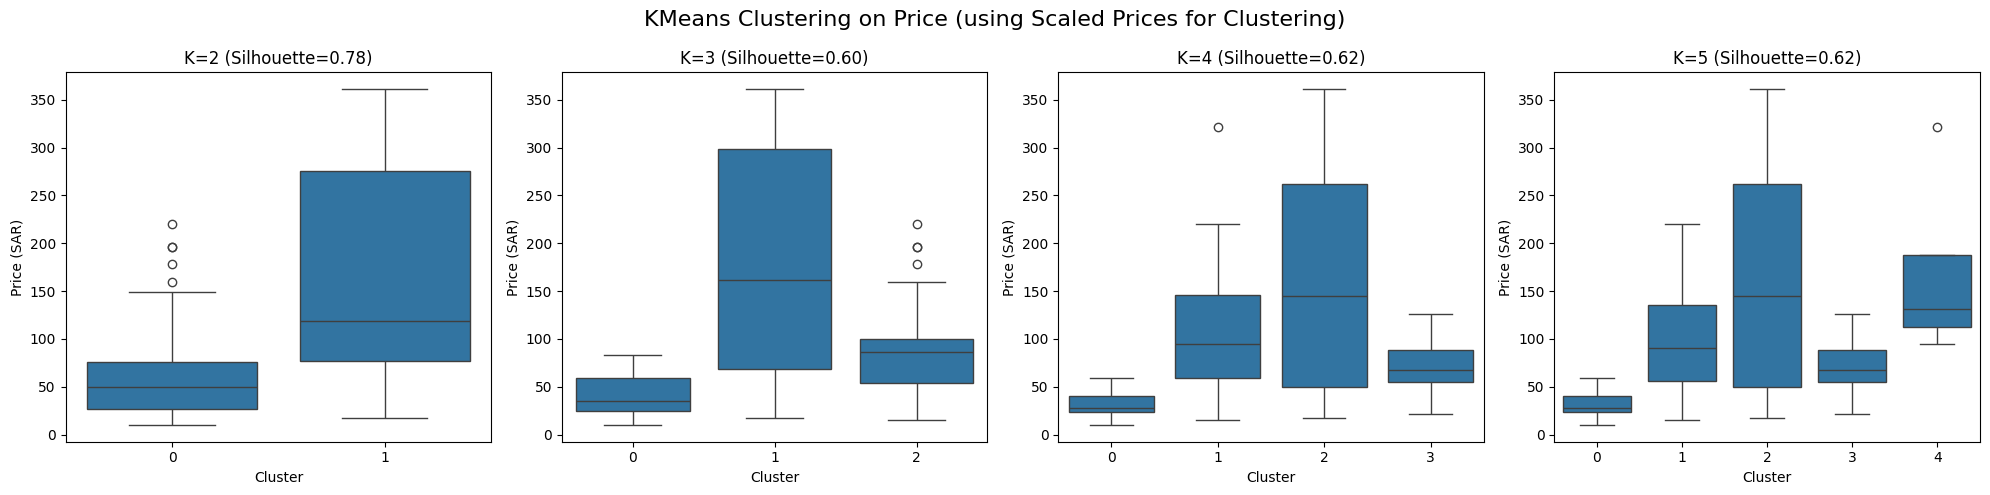

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


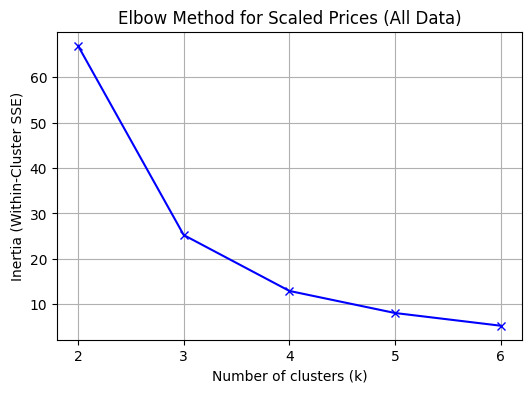

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_per_volume"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = {row["temp_cluster"]: new_label for new_label, row in cluster_means.iterrows()}

# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_per_volume"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count      mean       min       max
final_cluster                                     
0                 83  0.171128  0.022788  0.331800
1                 66  0.551432  0.349900  1.190000
2                  6  2.709501  1.599067  4.007333


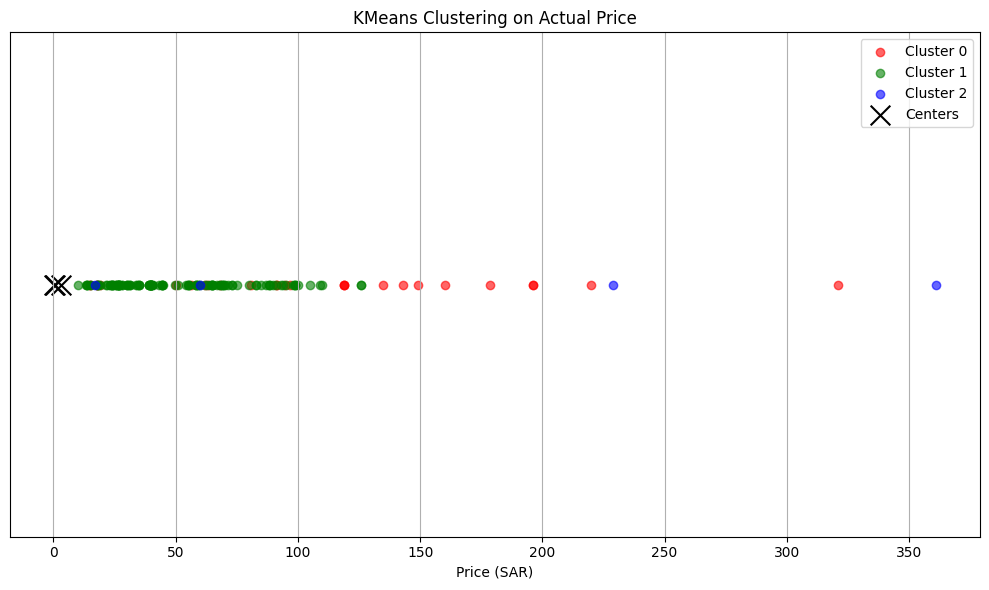

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_per_volume"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,"22# Fruity Body Spray,Hair and Body Mist,Hair ...",SAR 67.99,1.5 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,67.99,1.5,90.00000,0.755444,0.562722,0.955689,0,2,1,1,0
3,5815 Perfume For Unisex - 25 ml,SAR 17.89,3.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,17.89,3.6,25.00000,0.715600,0.539763,0.866444,0,2,1,1,0
4,"90ML Hair And Body Fragrance Mist,Brazilian Pe...",SAR 80.85,3.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,80.85,3.4,90.00000,0.898333,0.640976,1.259871,0,2,1,1,0
23,Bath & Body Works and - Rose - Ultra Shea Crea...,SAR 178.70,4.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,178.70,4.6,236.58800,0.755321,0.562652,0.955417,0,2,1,1,0
39,Body Mist for Women and Men. Long Lasting Upli...,SAR 63.36,4.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,63.36,4.1,100.00000,0.633600,0.490786,0.676067,0,2,1,1,0
56,"Cuide-Se Bem Cloud Body Splash, 200 Ml",SAR 321.00,4.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,321.00,4.1,200.00000,1.605000,0.957433,2.489968,1,1,1,4,0
60,ELEGANT BLUE BODY SPLASH 250ML,SAR 196.00,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,196.00,NaN,250.00000,0.784000,0.578858,1.018411,0,2,1,1,0
62,Enchanted Spring body spray for women 200ml - ...,SAR 160.00,4.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,160.00,4.8,200.00000,0.800000,0.587787,1.053117,0,2,1,1,0
83,Hair & Body Mist Pmgrte&Red Berries 150Ml,SAR 119.00,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,119.00,4.4,150.00000,0.793333,0.584076,1.038694,0,2,1,1,0
84,Hair Perfume & Body Fragrance Spray Mist - Dre...,SAR 118.84,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,118.84,4.0,192.22775,0.618225,0.481330,0.639309,0,2,1,1,0


In [18]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,A Thousand Wishes Fine Fragrance Mist - 236ml,SAR 65.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,65.00,4.3,236.000,0.275424,0.243278,-0.286020,0,0,3,3,1
6,AMBER ROMANCE BODY MIST (U) 250 ml,SAR 88.00,4.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,88.00,4.6,250.000,0.352000,0.301585,-0.059377,0,2,3,3,1
7,AMK Perfumed Splash and Shower Body Gel 800 ml...,SAR 18.23,2.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,18.23,2.0,800.000,0.022788,0.022532,-1.144084,0,0,0,0,1
8,AMK Perfumed Splash and Shower Body Gel 800 ml...,SAR 18.23,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,18.23,NaN,800.000,0.022788,0.022532,-1.144084,0,0,0,0,1
10,BAIN DE NATURE Scented Body Mist - Satin Sensu...,SAR 44.99,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,44.99,4.4,100.000,0.449900,0.371495,0.212369,0,2,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,body mist pink heart perfume 703 - 200 ML,SAR 13.46,3.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,13.46,3.6,200.000,0.067300,0.065132,-0.978492,0,0,0,0,1
187,body mist strawberries & champagne 250 ML,SAR 65.00,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,65.00,4.4,250.000,0.260000,0.231112,-0.333313,0,0,3,3,1
189,"by BATH & BODY WORKS, CRAZY FOR YOU FINE FRAGR...",SAR 58.50,3.9 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,58.50,3.9,236.588,0.247265,0.220953,-0.372799,0,0,3,3,1
190,"gold truck body spray 183 , 250 ml",SAR 23.00,3.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,23.00,3.2,250.000,0.092000,0.088011,-0.889560,0,0,0,0,1


In [19]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,title,price,rating,link,price_numeric,rating_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
9,Al-Tahara musk original white musk Perfume oil...,SAR 17.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,17.00,4.3,6.0,2.833333,1.343735,3.991562,1,1,2,2,2
50,Coconut Body Fragrance Mist 100 ml,SAR 361.00,4.4 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,361.00,4.4,100.0,3.610000,1.528228,4.708704,1,1,2,2,2
86,"In The Stars Fine Fragrance Mist For Women, Tr...",SAR 229.00,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,229.00,5.0,88.0,2.602273,1.281565,3.749902,1,1,2,2,2
94,Jamila For Women Perfume Oil 15ml,SAR 60.11,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,60.11,4.0,15.0,4.007333,1.610904,5.030073,1,1,2,2,2


KMeans clusters: 3
DBSCAN clusters: 9 (+ noise)


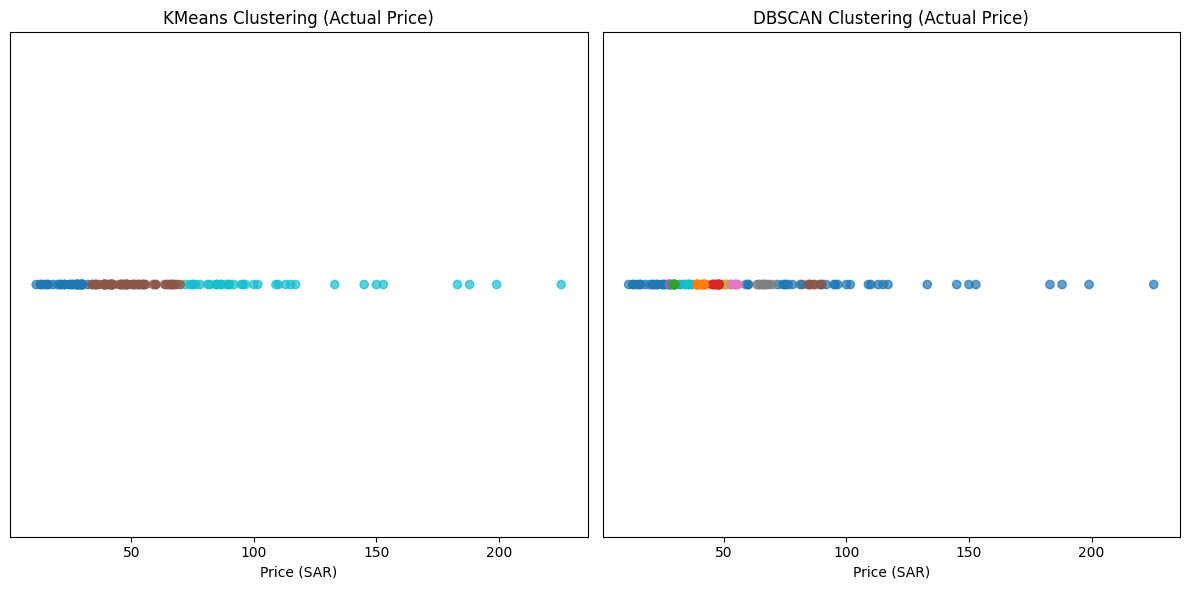

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

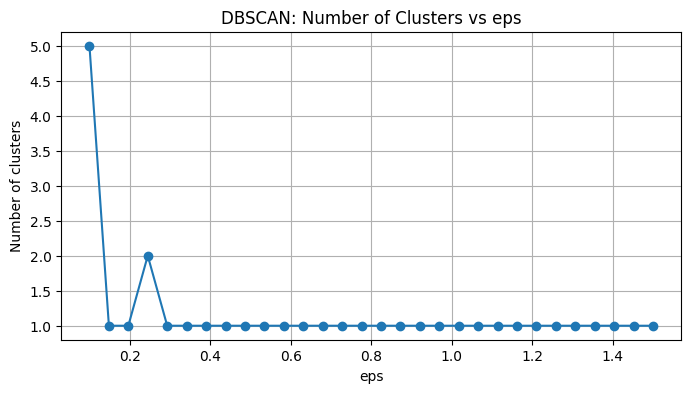

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""